In [1]:
# load(sage.env.SAGE_STARTUP_FILE)

In [2]:
import numpy as np
from tqdm import tqdm
from tqdm.notebook import trange, tqdm
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline
Parallelism().set(nproc=12)

## Integration of the wavelike equations

Without implying the stationary ansatz, the the wavelike equationseparates as

$$\frac{\partial^2\Psi}{\partial t^2} - \frac{\partial^2\Psi}{\partial r^2} +V\Psi = 0$$

Which can be rewritten in terms of the so called light-cone coordinates 

$$du = dt − dr_\star \qquad \text{and} \qquad dv = dt + dr_\star$$

Resulting
$$4\frac{\partial^2 \Psi}{\partial u \partial v} +V\Psi= 0$$

Such equations can be discretized and solved numerically

It gives a recurrence relation

$$\Psi(u_{i+1},v_{j+1}) = \Psi(u_{i+1},v_{j}) + \Psi(u_{i},v_{j+1}) - \Psi(u_{i},v_{j}) - \frac{\Delta u \Delta v}{8}\left[\Psi(u_{i},v_{j+1})+\Psi(u_{i+1},v_{j})\right]V(u_{i+1},v_{j})$$

**Initial conditions**

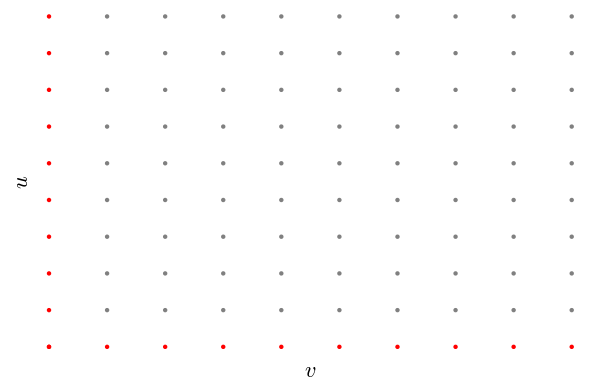

In [3]:
list_points = [(k,l) for k in range(2,11) for l in range(2,11)]
list_points_ics = [(k,1) for k in range(1,11)] + [(1,l) for l in range(1,11)]
list_plot(list_points, color='gray')+\
 list_plot(list_points_ics, color='red', axes_labels=['$v$','$u$'], axes=False, frame=False)

In [4]:
var('M μ')
ℓ = var('ℓ')
value_M = 1.0
value_ℓ = 1
value_μ = 0
V(r) = -2*M*μ^2/r + μ^2 - 2*M*(ℓ + 1)*ℓ/r^3 + (ℓ + 1)*ℓ/r^2 - 4*M^2/r^4 + 2*M/r^3
fast_V = fast_callable(V(r).subs({M:value_M, ℓ:value_ℓ, μ:value_μ}), vars=[r])

drt = r^2/(r^2-2*M*r)
tortoise = (integral(drt,r)-2*M*log(2*M)).simplify_log()
fast_tortoise = fast_callable(tortoise.subs({M:value_M}), vars=[r])

In [5]:
# we solve the scattering problem of a massless scalar field around a Schwarzschild black hole
#in the time domain. We follow the method described in Phys.Rev. D49 (1994) 883-889 [arXiv:gr-qc/9307009], 
#by Gundlach, Price and Pullin.

# We first define the parameters :

bh_m = value_M #(*mass of the black hole*); 
rh =  2*bh_m #(*location of the event horizon*); 
l = value_ℓ #(*orbital quantum number*); 
umax = 400 #(*max value of the u coordinate*); 
umin = -50 #(*min value of the u coordinate*); 
vmax = 400 #(*max value of the v coordinate*); 
vmin = -50 #(*min value of the v coordinate*);
nu = 699; nv = 699; #(* number of points in the grid *);
du = (umax - umin)/(nu + 1) #(*step size for u *); 
dv = (umax - umin)/( nv + 1) #(*step size for v *); 
i0 = -50 #(* initial i value *); 
j0 = -50 #(* initial j value *);

In [6]:
ndv = np.arange(i0,nv,dv)
ndu = np.arange(j0,nu,du)
ndv.size,ndu.size

(1166, 1166)

In [7]:
rr1 = np.arange(2*bh_m+10**-10, 2+10**-3,10**-5)
rr2 = np.arange(2*bh_m+2*10**-3, 2+1*10**-1,10**-3)
rr3 = np.linspace(2*bh_m+2*10**-1,200, ndv.size-rr1.size-rr2.size)

nr = np.concatenate((rr1,rr2,rr3))

ttt = fast_tortoise(nr)
rs_spline = spline(list(zip(ttt,nr))) #sage/GSL spline
rs = interpolate.interp1d(ttt, nr, fill_value='extrapolate')

In [8]:
rs_valores = np.linspace(-40,100,400)
l_data = list(zip(rs_valores,rs(rs_valores)))

In [9]:
#(* Gaussian to be used as the initial condition *) 
a = 1/100; b = 30; c = 3;
gaus(x) = a*exp(-(x - b)^2/(2*c^2))
gs = fast_callable(gaus,vars=[x])

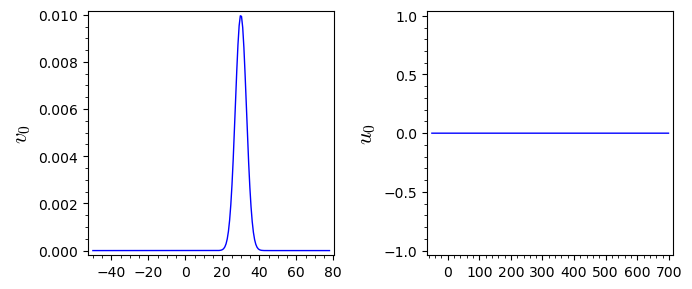

In [10]:
gv0 = list_plot(list(zip(ndv[:200],gs(ndv[:200]))), plotjoined=True, axes=False, frame=True, axes_labels=[r'',r'$v_0$'])
gu0 = list_plot(list(zip(ndv,-gs(0*ndv))), plotjoined=True, axes=False, frame=True, axes_labels=[r'',r'$u_0$'])
graphics_array([gv0, gu0]).show(figsize=[7,3])                

In [11]:
frs(x) = 1/4*((2*x + 1))
fast_rs = fast_callable(frs, vars=[x])
def funcnV(x,y):
    return fast_V(rs(fast_rs(x)*dv - fast_rs(y)*du))
X,Y = np.meshgrid(ndv[:-2],ndu[:-2])
nV = funcnV(X,Y)

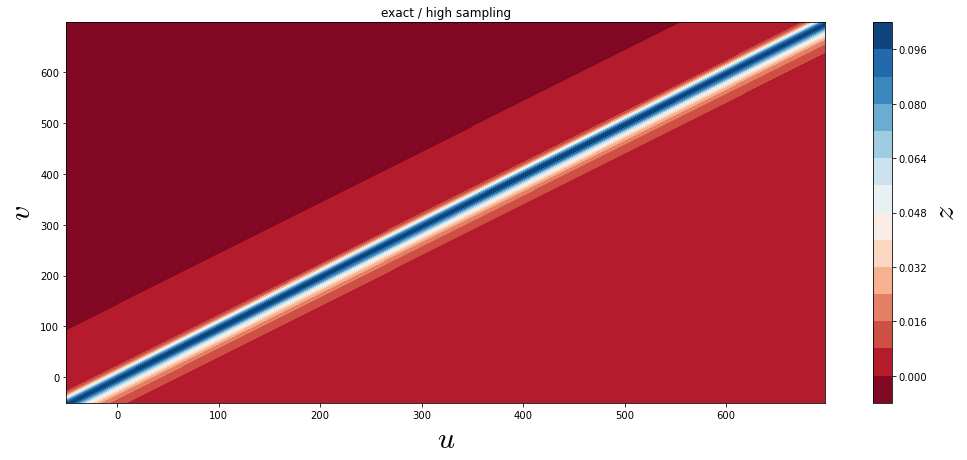

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(17, 7))
c = axes.contourf(X, Y, funcnV(X,Y), 15, cmap=plt.cm.RdBu)
axes.set_xlabel(r"$u$", fontsize=30)
axes.set_ylabel(r"$v$", fontsize=30)
axes.set_title("exact / high sampling")
cb = fig.colorbar(c, ax=axes)
cb.set_label(r"$z$", fontsize=30)

$$u=v \Rightarrow r_\star  = 0$$

In [13]:
# implementing the recurrence relation
def calc_psi(ndv,ndu):
    psi = np.zeros((ndv.size,ndv.size))
    psi[:,0] = gs(ndv)
    psi[0,:] = gs(0)
    for j in tqdm(range(ndu.size-2)):
        for i in range(ndv.size-2):
            psi[i+1,j+1] = psi[i+1,j]+psi[i,j+1]-psi[i,j]-(du*dv/8)*(psi[i,j+1]+psi[i+1,j])*nV[i,j]
    return psi

In [14]:
n_psi = calc_psi(ndv,ndu)

  0%|          | 0/1164 [00:00<?, ?it/s]

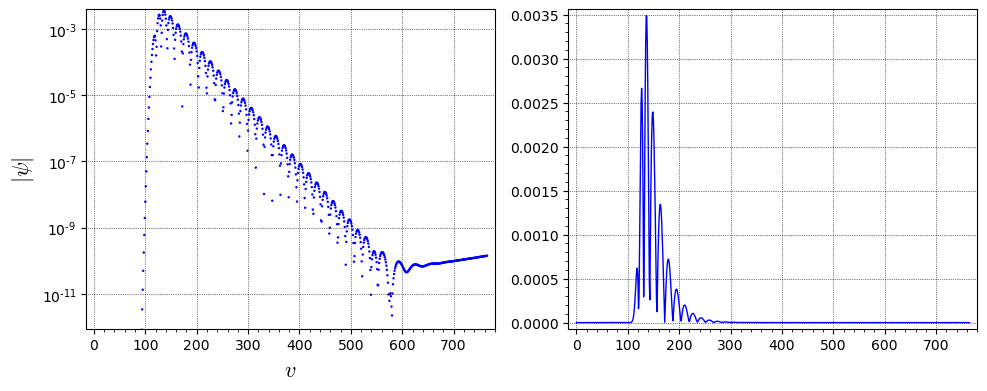

In [15]:
pl00 = list_plot(abs(n_psi[:-400,-2]),ymin=1e-12,size=3, gridlines=True,axes=False, frame=True, scale='semilogy', axes_labels=['$v$',r'$|\psi|$'])
pl01 = list_plot(abs(n_psi[:-400,-2]),ymin=1e-12, gridlines=True,  plotjoined=True, axes=False, frame=True)
graphics_array([pl00,pl01]).show(figsize=[10,4])

***

## Extraction of the wave function $\Psi(t,r_\star)$ for fixed $r_\star$

We would like to : 
1. transform $\Psi(v, u)$ into $\Psi(t, r_\star)$, 
2. fix $r_\star = r_e$ (extraction radius), and 
3. obtain $\Psi(t, r_e)$. 

After that, we can plot $\Psi(t, r_e)$, from $t_\text{min}$ to $t_\text{max}$. Since the grid has a finite size, 
 we need to determine what values we should use for tmin and tmax

In [16]:
rext = 3; tmin = rext; tmax = min(vmax - rext, umax + rext);

In [17]:
psi_i = interpolate.interp2d(ndv, ndu, n_psi, kind='cubic')
psi_i(ndv,ndu).shape

(1166, 1166)

In [18]:
var('t r')
nt = np.linspace(tmin,tmax,ndv.size)
Psi = {t:psi_i(nt+rext,nt-rext), r: psi_i(tmin+nr,tmin-nr)}

def Psi_r(value):
    return psi_i(value+nr,value-nr)

def Psi_t(value):
    return psi_i(nt+value,nt-value)

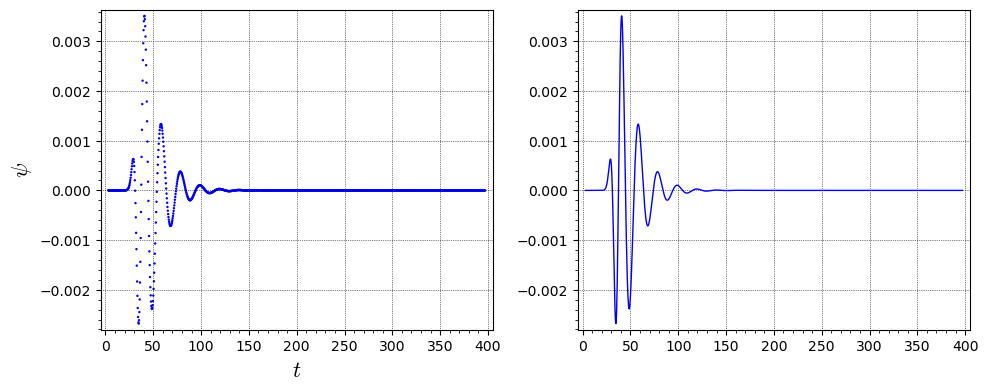

In [19]:
data_P0 = list(zip(nt,Psi[t][:,-1]))
pl10 = list_plot(data_P0, size=3, axes=False, frame=True, gridlines=True,axes_labels=['$t$',r'$\psi$'])
pl11 = list_plot(data_P0, plotjoined=True, axes=False, frame=True, gridlines=True)
graphics_array([pl10,pl11]).show(figsize=[10,4])

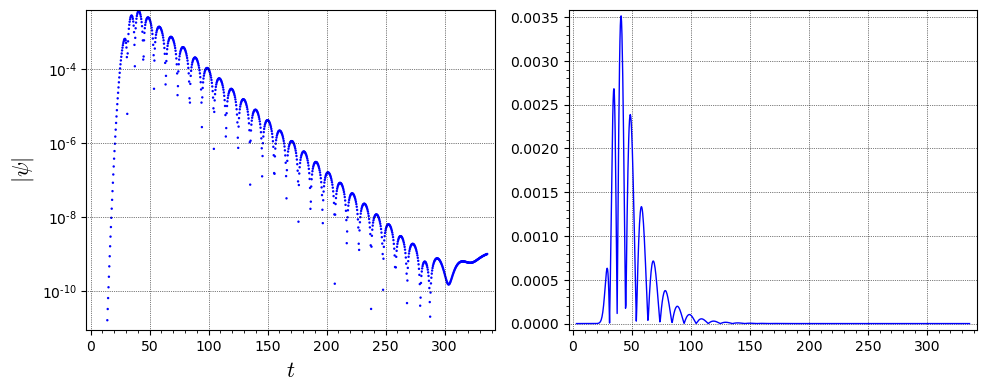

In [20]:
data_P = list(zip(nt,abs(Psi[t][:-180,-1])))
pl20 = list_plot(data_P, scale='semilogy',ymin=1e-11, size=3,axes=False,frame=True, gridlines=True, axes_labels=['$t$',r'$|\psi|$'])
pl21 = list_plot(data_P, ymin=1e-9, plotjoined=True,axes=False,frame=True, gridlines=True)
graphics_array([pl20,pl21]).show(figsize=[10,4])

In [ ]:
#pl21.save('freq.png', gridlines=True, size=3, frame=True, axes=False, figsize=[14,6],  axes_labels=['$t$',r'$|\psi|$'])

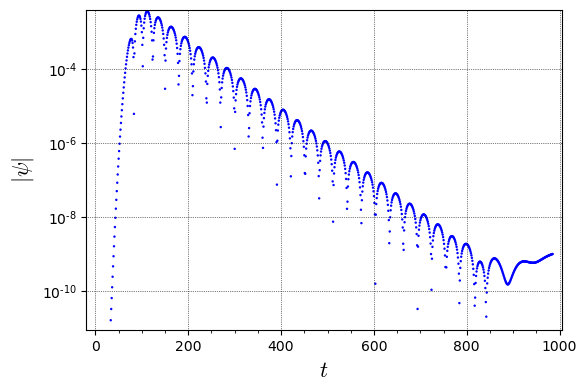

In [21]:
list_plot(abs(Psi[t][:-180,-1]), scale='semilogy',ymin=1e-11, size=3,axes=False,frame=True, gridlines=True, axes_labels=['$t$',r'$|\psi|$'])

In [22]:
frames_t = [list_plot(list(zip(ttt,np.flip(Psi_t(k)[:,-1]))), ymin=-.0035, ymax=.0035, axes=False, frame=True,plotjoined=True, 
                      gridlines=True,axes_labels=[r'$r_\star/M$',r'$\psi$']) for k in range(300,100,-3)]

In [23]:
ann = animate(frames_t)

Animation with 67 frames
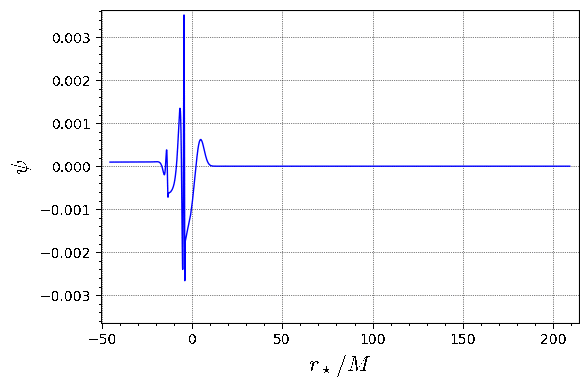

In [24]:
ann

In [26]:
ann.gif(savefile='my_animation.gif', show_path=True) # optional

Animation saved to file /home/oem/Documentos/Mestrado/Teoria Perturbativa de Buracos Negros/my_animation.gif.
